In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from core import DataLoader

In [2]:
Christianity = DataLoader('../data/christianity')

In [3]:
Judaism = DataLoader('../data/judaism')

## Związek wzrostów użycia tagów z wydarzeniami światu rzeczywistego

Chcemy przeanalizować związek między wzrostem częstotliwości wystąpienia postów z wybranymi tagami w latach a wydarzeniami na świecie związanymi z tymi tagami. W tym celu najpierw obliczymy rozkład częstotliwości pojawienia się postów posiadających przekazane tagi.

Funkcja zwracająca ilość wystąpień postów z tagami **tags**.

In [54]:
def tags_accuracy_by_years(data, tags):
    posts = data.posts_df.set_index('Id')
    post_history = data.postHistory_df.set_index('PostId')
    df = posts.merge(post_history, left_on='Id', right_on='PostId', how='inner', suffixes=('Posts', 'History'))
    posts_with_tags = df[df.Tags.str.contains('|'.join(tags), na=False) & df.PostHistoryTypeId == 1]
    posts_with_tags.CreationDatePosts = pd.to_datetime(posts_with_tags.CreationDatePosts)
    result = pd.DataFrame({
        'CreationYear': posts_with_tags.CreationDatePosts.dt.year})
    return result.groupby(['CreationYear'])['CreationYear'].size()

Spróbujemy znaleźć wzrosty wystąpień tagów związanych z LGBT w latach, kiedy miały miejsce poważne protesty przeciwko dyskryminacji.

C:\Users\forti\AppData\Local\Temp\ipykernel_4492\356626897.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts_with_tags.CreationDatePosts = pd.to_datetime(posts_with_tags.CreationDatePosts)
C:\Users\forti\AppData\Local\Temp\ipykernel_4492\356626897.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts_with_tags.CreationDatePosts = pd.to_datetime(posts_with_tags.CreationDatePosts)


<AxesSubplot:xlabel='CreationYear'>

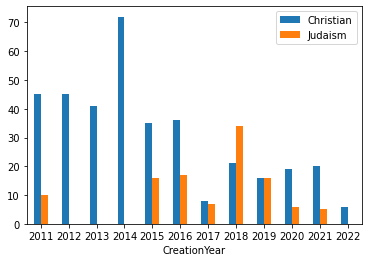

In [55]:
tags = ['<homosexuality>', '<pride>']

chris = tags_accuracy_by_years(Christianity, tags)
jud = tags_accuracy_by_years(Judaism, tags)

result = pd.DataFrame({'Christian': chris, 'Judaism': jud})
result.plot.bar(rot=0)

Widzimy mocny wzrost częstotliwości pojawienia się tagów w 2014 roku dla zbioru danych z forumu o chrześcijaństwie, który może być związany z protestami podczas igrzysk olimpijskiсh (https://en.wikipedia.org/wiki/LGBT_rights_protests_surrounding_the_2014_Winter_Olympics).

Również możemy obserwować wsrost w 2018 roku dla zbioru z forumu o judaizmie. Ten wzrost może być związany z protestami w Izraelu (https://en.wikipedia.org/wiki/2018_Israeli_LGBT%27s_strike#:~:text=On%20July%2022%2C%202018%20Israeli,towards%20the%20Israeli%20trans%20community).

Teraz spróbujemy sprawdzić, czy wzrost wystąpień LGBT-tagów w 2018 roku rzeczywiście jest związany z protestami w Izraelu. W tym celu znajdziemy rozkład częstotliwości wystąpień ww. tagów w krajach w 2018 roku.

Funkcja zwracająca iłość wystąpień postów z tagami **tags** w roku **year** w **n_countries** krajach wskazanych przez największą iłość użytkowników.

In [56]:
def tags_accuracy_by_countries_at_year(data, tags, year, n_countries):
    users = pd.concat([Christianity.users_df, Judaism.users_df], sort=False)
    countries = [c for c in calculate_countries(users, n_countries) if type(c) == str]

    posts = data.posts_df.set_index('OwnerUserId')
    users = data.users_df.set_index('Id')
    users = standardize_countries(users)
    
    df = posts.merge(users, left_on='OwnerUserId', right_on='Id', how='inner', suffixes=('Posts', 'Users'))
    df.CreationDatePosts = pd.to_datetime(df.CreationDatePosts)

    posts_with_tags = df[df.Tags.str.contains('|'.join(tags), na=False) 
        & (df.Location.str.contains('|'.join(countries), na=False)) 
        & (df.CreationDatePosts.dt.year == year)]
    result = pd.DataFrame({
        'Country': posts_with_tags.Location})

    return result.groupby(by=result.Country).size()

Funkcja zwracająca **n_countries** krajów wskazanych przez największą iłość użytkowników.

In [57]:
def calculate_countries(users, n_countries):
    users = standardize_countries(users)
    s = users.groupby(['Location']).size()
    d = pd.DataFrame({'Country': s.index, 'Number': s.values})
    d = d.sort_values(by=['Number'], ascending=False)
    
    return d['Country'][:n_countries]

Skoro serwisy StackExchange pozwolają użytkownikom na wprowadzenie czegokolwiek do pola **Location**, żeby usyzkać rozsądne dane do analizy musimy przeprowadzić pewną normalizację tych danych. Ta normalizacja będzie polegała na poszukiwaniu w pole **Location** podciągów zawierających nazwę albo skrót krainy i oraz podmianie tego pola na zapowiedzianą nazwę kraju.

Funkcja przyjmująca dataframe **users** i zwracająca ten sam dataframe o znormalizowanym polu **Location**.

In [58]:
def standardize_countries(users):
    aliases = {
        'USA': ['USA', 'US', 'United States'],
        'UK': ['UK', 'United Kingdom', 'GB', 'Great Britain'],
        'Israil': ['Israil', 'Israel'],
        'France': ['France'],
        'Germany': ['Germany'],
        'India': ['India'],
        'Thailand': ['Thai'],
        'Indonesia': ['Indonesia'],
        'Brazil': ['Brazil'],
        'Australia': ['Australia'],
        'Canada': ['Canada'],
        'Poland': ['Poland'],
        'Russia': ['Russia'],
    }
    
    for alias, names in aliases.items():
        for country in names:
            users['Location'] = users['Location'].apply(
                lambda x: alias 
                if x and country in str(x) 
                else x)

    users['Location'] = users['Location'].apply(
        lambda x: x[x.rindex(','):].replace(',', '').replace(' ', '') 
        if type(x) == str and ',' in x 
        else x)
    
    return users
            

Spróbujemy znaleźć iłość wystąpień LGBT-tagów w 2018 roku w 50 krajach o największej liczbie użytkowników.

<AxesSubplot:xlabel='Country'>

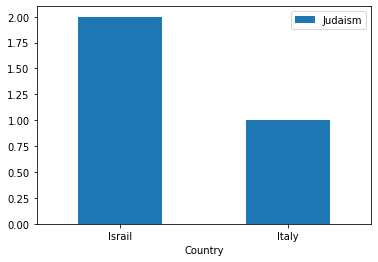

In [60]:
tags = ['<homosexuality>', '<pride>']
n_countries = 50
year = 2018

jud = tags_accuracy_by_countries_at_year(Judaism, tags, year, n_countries)

result = pd.DataFrame({'Judaism': jud})

result.plot.bar(rot=0)

Otrzymane wyniki mogą wydawać się dziwne. Rzeczywiście, pierwsza część analizy pokazała, że w 2018 roku powstały 34 posty, przecież spośród 50 krajów o największej iłości użytkowników znaleźliśmy tylko 3 posty o podanych tagach. Jednak da się wyprowadzić z tego kilka ważnych wniosków:

1. W skutek tego, że wybrany zbiór danych nie ma ustawionego formatu lokalizacji, analiza tych danych jest bardzo utrudniona, a zaimplementowany algorytm normalizacji jest nie wystarczająco *mądry*. Możemy stwierdzić, że wybrany dataset nie odpowiada tego typu analizie.

2. Nie wykryliśmy wzrostu wykorzystania wybranych tagów w Izraelu, a zatem wzrost wystąpień LGBT-tagów w 2018 roku nie jest związany z protestami. Czyli, w badanym zbiorze danych częstotliwości wystąpienia postów z wybranymi tagami w latach nie są związane z wydarzeniami na świecie związanymi z tymi tagami.